In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

In [2]:
print(f"Scikit-Learn Version: {sklearn.__version__}")

Scikit-Learn Version: 1.7.1


In [3]:
# ============================================================
# DATA LOADING AND PREPARATION
# ============================================================

df = pd.read_csv('course_lead_scoring.txt')
print(f"Dataset shape: {df.shape}")

Dataset shape: (1462, 9)


In [4]:
# Replace missing values
# Categorical features: replace with 'NA'
df['industry'] = df['industry'].fillna('NA').replace('', 'NA')
df['lead_source'] = df['lead_source'].fillna('NA').replace('', 'NA')
df['employment_status'] = df['employment_status'].fillna('NA').replace('', 'NA')
df['location'] = df['location'].fillna('NA').replace('', 'NA')

In [5]:
# Numerical features: replace with 0.0
df['number_of_courses_viewed'] = df['number_of_courses_viewed'].fillna(0.0)
df['annual_income'] = df['annual_income'].fillna(0.0)
df['interaction_count'] = df['interaction_count'].fillna(0.0)
df['lead_score'] = df['lead_score'].fillna(0.0)

print(f"Missing values after preparation:\n{df.isnull().sum()}")

Missing values after preparation:
lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [6]:
# ============================================================
# QUESTION 1: INDUSTRY MODE
# ============================================================

In [7]:
industry_mode = df['industry'].mode()[0]
industry_counts = df['industry'].value_counts()

print(f"\n{'='*60}")
print(f"QUESTION 1: Industry Mode")
print(f"{'='*60}")
print(f"Mode (Most Frequent Value): {industry_mode}")
print(f"\nIndustry Distribution:")
print(industry_counts)


QUESTION 1: Industry Mode
Mode (Most Frequent Value): retail

Industry Distribution:
industry
retail           203
finance          200
other            198
healthcare       187
education        187
technology       179
manufacturing    174
NA               134
Name: count, dtype: int64


In [8]:
# ============================================================
# DATA SPLIT (for Questions 2-6)
# ============================================================

In [9]:
X = df.drop('converted', axis=1)
y = df['converted']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"\n{'='*60}")
print(f"DATA SPLIT: 60/20/20")
print(f"{'='*60}")
print(f"Train set size: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")


DATA SPLIT: 60/20/20
Train set size: 877 (60.0%)
Validation set size: 292 (20.0%)
Test set size: 293 (20.0%)


In [10]:
# ============================================================
# QUESTION 2: CORRELATION MATRIX
# ============================================================

In [11]:
numerical_features = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
df_numerical = df[numerical_features]
correlation_matrix = df_numerical.corr()

print(f"\n{'='*60}")
print(f"QUESTION 2: Correlation Matrix")
print(f"{'='*60}")
print(correlation_matrix)


QUESTION 2: Correlation Matrix
                          number_of_courses_viewed  annual_income  \
number_of_courses_viewed                  1.000000       0.009770   
annual_income                             0.009770       1.000000   
interaction_count                        -0.023565       0.027036   
lead_score                               -0.004879       0.015610   

                          interaction_count  lead_score  
number_of_courses_viewed          -0.023565   -0.004879  
annual_income                      0.027036    0.015610  
interaction_count                  1.000000    0.009888  
lead_score                         0.009888    1.000000  


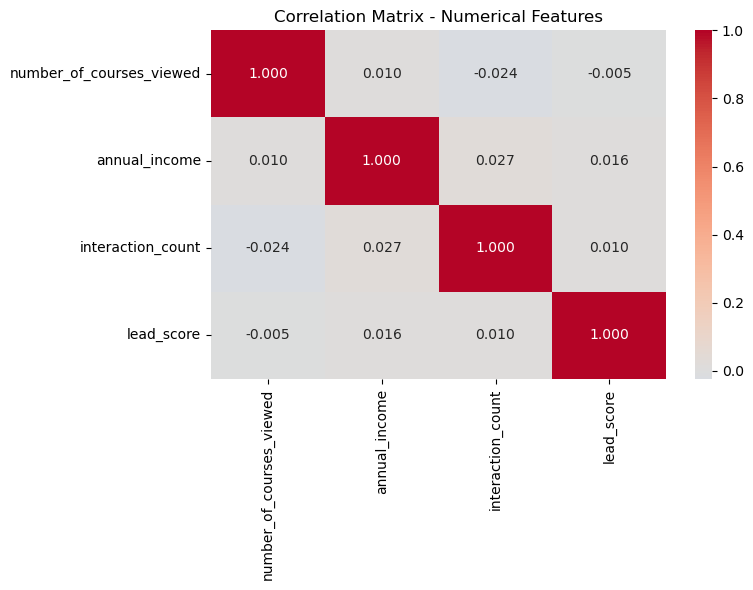


Correlation values for specified pairs (sorted by magnitude):
annual_income & interaction_count: 0.027036
number_of_courses_viewed & interaction_count: -0.023565
interaction_count & lead_score: 0.009888
number_of_courses_viewed & lead_score: -0.004879

Biggest Correlation Pair: annual_income & interaction_count
Coefficient: 0.027036


In [12]:
# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Correlation Matrix - Numerical Features')
plt.tight_layout()
plt.show()

pairs = [
    ('interaction_count', 'lead_score'),
    ('number_of_courses_viewed', 'lead_score'),
    ('number_of_courses_viewed', 'interaction_count'),
    ('annual_income', 'interaction_count')
]

correlations = []
for feat1, feat2 in pairs:
    corr_value = correlation_matrix.loc[feat1, feat2]
    correlations.append({
        'Pair': f"{feat1} & {feat2}",
        'Correlation': corr_value,
        'Abs_Correlation': abs(corr_value)
    })

correlations_sorted = sorted(correlations, key=lambda x: x['Abs_Correlation'], reverse=True)

print("\nCorrelation values for specified pairs (sorted by magnitude):")
for item in correlations_sorted:
    print(f"{item['Pair']}: {item['Correlation']:.6f}")

biggest_corr = correlations_sorted[0]
print(f"\nBiggest Correlation Pair: {biggest_corr['Pair']}")
print(f"Coefficient: {biggest_corr['Correlation']:.6f}")

In [13]:
# ============================================================
# QUESTION 3: MUTUAL INFORMATION SCORE
# ============================================================

In [15]:
print(f"\n{'='*60}")
print(f"QUESTION 3: Mutual Information Score")
print(f"{'='*60}")

categorical_features = ['industry', 'location', 'lead_source', 'employment_status']

X_train_encoded = X_train.copy()
label_encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    X_train_encoded[feature] = le.fit_transform(X_train[feature])
    label_encoders[feature] = le

mi_scores = mutual_info_classif(X_train_encoded[categorical_features], y_train, random_state=42)

results = pd.DataFrame({
    'Feature': categorical_features,
    'Mutual Information Score': mi_scores
})

results['Mutual Information Score'] = results['Mutual Information Score'].apply(lambda x: round(x, 2))
results = results.sort_values('Mutual Information Score', ascending=False)

print("Mutual Information Scores (sorted):")
print(results.to_string(index=False))

biggest_score_feature = results.iloc[0]['Feature']
biggest_score_value = results.iloc[0]['Mutual Information Score']
print(f"\nFeature with Biggest MI Score: {biggest_score_feature} ({biggest_score_value})")



QUESTION 3: Mutual Information Score
Mutual Information Scores (sorted):
          Feature  Mutual Information Score
employment_status                      0.04
         industry                      0.02
      lead_source                      0.01
         location                      0.00

Feature with Biggest MI Score: employment_status (0.04)


In [16]:
# ============================================================
# QUESTION 4: LOGISTIC REGRESSION (C=1.0)
# ============================================================

In [17]:
print(f"\n{'='*60}")
print(f"QUESTION 4: Logistic Regression (C=1.0)")
print(f"{'='*60}")

categorical_features = ['industry', 'location', 'lead_source', 'employment_status']
numerical_features = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ])

model_q4 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42))
])

model_q4.fit(X_train, y_train)
y_val_pred_q4 = model_q4.predict(X_val)
val_accuracy_q4 = accuracy_score(y_val, y_val_pred_q4)
val_accuracy_q4_rounded = round(val_accuracy_q4, 2)

print(f"Validation Accuracy: {val_accuracy_q4_rounded}")
print(f"\nClassification Report:")
print(classification_report(y_val, y_val_pred_q4, target_names=['Not Converted', 'Converted']))



QUESTION 4: Logistic Regression (C=1.0)
Validation Accuracy: 0.74

Classification Report:
               precision    recall  f1-score   support

Not Converted       0.70      0.37      0.48        95
    Converted       0.75      0.92      0.83       197

     accuracy                           0.74       292
    macro avg       0.73      0.65      0.66       292
 weighted avg       0.74      0.74      0.72       292



In [18]:
# ============================================================
# QUESTION 5: FEATURE ELIMINATION
# ============================================================

In [19]:
print(f"\n{'='*60}")
print(f"QUESTION 5: Feature Elimination")
print(f"{'='*60}")

baseline_accuracy = val_accuracy_q4
features_to_test = ['industry', 'employment_status', 'lead_score']
elimination_results = []

for feature_to_drop in features_to_test:
    cat_features_reduced = [f for f in categorical_features if f != feature_to_drop]
    num_features_reduced = [f for f in numerical_features if f != feature_to_drop]
    
    preprocessor_reduced = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features_reduced) if cat_features_reduced else ('cat', 'drop', []),
            ('num', 'passthrough', num_features_reduced) if num_features_reduced else ('num', 'drop', [])
        ])
    
    model_reduced = Pipeline(steps=[
        ('preprocessor', preprocessor_reduced),
        ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42))
    ])
    
    model_reduced.fit(X_train[cat_features_reduced + num_features_reduced], y_train)
    y_val_pred_reduced = model_reduced.predict(X_val[cat_features_reduced + num_features_reduced])
    reduced_accuracy = accuracy_score(y_val, y_val_pred_reduced)
    difference = baseline_accuracy - reduced_accuracy
    
    elimination_results.append({
        'Feature': feature_to_drop,
        'Accuracy without feature': reduced_accuracy,
        'Difference (baseline - without)': difference
    })

results_elim = pd.DataFrame(elimination_results)
results_elim = results_elim.sort_values('Difference (baseline - without)', ascending=True)

print(f"Baseline Accuracy: {baseline_accuracy}")
print("\nFeature Elimination Results (sorted by difference):")
print(results_elim.to_string(index=False))

smallest_diff_feature = results_elim.iloc[0]['Feature']
smallest_diff_value = results_elim.iloc[0]['Difference (baseline - without)']
print(f"\nFeature with Smallest Difference: {smallest_diff_feature}")
print(f"Difference: {smallest_diff_value}")


QUESTION 5: Feature Elimination
Baseline Accuracy: 0.7431506849315068

Feature Elimination Results (sorted by difference):
          Feature  Accuracy without feature  Difference (baseline - without)
employment_status                  0.746575                        -0.003425
         industry                  0.743151                         0.000000
       lead_score                  0.743151                         0.000000

Feature with Smallest Difference: employment_status
Difference: -0.003424657534246589


In [20]:
# ============================================================
# QUESTION 6: HYPERPARAMETER TUNING (C values)
# ============================================================

In [21]:
print(f"\n{'='*60}")
print(f"QUESTION 6: Hyperparameter Tuning - C Values")
print(f"{'='*60}")

C_values = [0.01, 0.1, 1, 10, 100]
tuning_results = []

for C in C_values:
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', 'passthrough', numerical_features)
        ])
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42))
    ])
    
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_accuracy_rounded = round(val_accuracy, 3)
    
    tuning_results.append({
        'C': C,
        'Validation Accuracy': val_accuracy,
        'Validation Accuracy (rounded to 3)': val_accuracy_rounded
    })

results_tuning = pd.DataFrame(tuning_results)
results_tuning_sorted = results_tuning.sort_values('Validation Accuracy', ascending=False)

print("Results (sorted by validation accuracy):")
print(results_tuning_sorted.to_string(index=False))

best_C = results_tuning_sorted.iloc[0]['C']
best_accuracy = results_tuning_sorted.iloc[0]['Validation Accuracy (rounded to 3)']

print(f"\nBest C value: {best_C}")
print(f"Validation Accuracy: {best_accuracy}")

print("\nResults ordered by C value:")
results_tuning_ordered = pd.DataFrame(tuning_results).sort_values('C')
print(results_tuning_ordered[['C', 'Validation Accuracy (rounded to 3)']].to_string(index=False))


QUESTION 6: Hyperparameter Tuning - C Values
Results (sorted by validation accuracy):
     C  Validation Accuracy  Validation Accuracy (rounded to 3)
  0.01             0.743151                               0.743
  0.10             0.743151                               0.743
  1.00             0.743151                               0.743
 10.00             0.743151                               0.743
100.00             0.743151                               0.743

Best C value: 0.01
Validation Accuracy: 0.743

Results ordered by C value:
     C  Validation Accuracy (rounded to 3)
  0.01                               0.743
  0.10                               0.743
  1.00                               0.743
 10.00                               0.743
100.00                               0.743
